# Probabilistic iLQR 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from scipy.stats import multivariate_normal as mvn
from ocp import *
import pdb
import os
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Creating a 2nd order unicycle 

#### Creating a Pendulum

In [ ]:
sys = Pendulum(dt = 0.05)
sys_name = 'Inverted_Pendulum'
sys.b = 0.01
x0 = np.array([4*np.pi/4, 0])
sys.set_init_state(x0)

T = 200
us = np.zeros((T,sys.Du))
xs = sys.rollout(us)
x_ref = np.array([0,0]) #for pendulum
# sys.plot_traj(xs, dt = 0.01)

#### Creating a Bicopter 

##  Using Class

#### Define cost parameters 

In [34]:
if sys_name == 'Bicopter':
    Q = np.eye(sys.Dx)*0.
    #Q[1,1] *= 10
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*100
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.1
elif sys_name == 'Inverted_Pendulum':
    Q = np.eye(sys.Dx)*0.1
    Q[1,1] *= 1
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*300
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.3
elif sys_name == 'Unicycle':
    Q = np.eye(sys.Dx)*0.1
    #Q[1,1] *= 10
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*300
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.1
    
    
    
mu = 1e-6

In [35]:
ilqr = ILQR_Standard(sys)
ilqr.set_init_state(x0)
ilqr.set_timestep(T)
ilqr.set_cost(Q,R,Qf)
ilqr.set_ref(np.zeros((T+1,sys.Dx)))

In [36]:
if sys_name == 'Bicopter':
    x_ref = np.array([2,2,0,0,0,0]) #for bicopter
elif sys_name == 'Inverted_Pendulum':
    x_ref = np.array([0,0]) #for pendulum
elif sys_name == 'Unicycle':
    x_ref = np.array([2,2,-np.pi/2,0,0]) #for 2nd order unicycle
    #x_ref = np.array([2,2,0]) #for 1st order unicycle
x_refs = np.array([x_ref]*(ilqr.T +1))

In [37]:
ilqr.set_ref(x_refs)

In [51]:
us = np.zeros((T+1,sys.Du))
sys.set_init_state(x0)
xs = sys.rollout(us[:-1])
ilqr.set_state(xs,us)

Text(0.5, 1.0, 'Inverted_Pendulum')

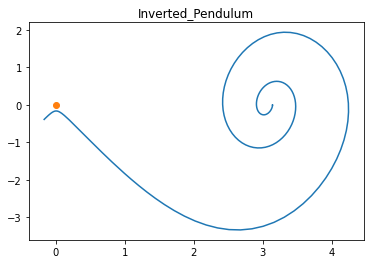

In [53]:
ilqr.solve(50, method='batch')
clear_output()
#plt.plot(ilqr.xs[:,1], '-')
plt.plot(ilqr.xs[:,0],ilqr.xs[:,1], '-')
plt.plot(x_ref[0], x_ref[1], 'o')
plt.title(sys_name)

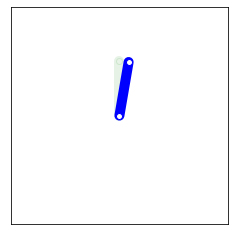

In [55]:
xs = np.concatenate([ilqr.xs[:], [ilqr.xs[-1]]*10])

if sys_name == 'Inverted_Pendulum':
    sys.plot_traj(xs, dt=0.01,  goal=x_ref, alpha=0.1)
elif sys_name == 'Bicopter':
    sys.vis_traj(xs, axes_lim=[-2.5,2.8,-2.5,2.8], dt=0.01, goal=x_ref, alpha=0.2)
elif sys_name == 'Unicycle':
    sys.plot_traj(xs, goal=x_ref)